# Renewable Energy Forecasting - Germany

**Goal:** Predict day-ahead hourly generation for Solar, Wind Onshore, and Wind Offshore

**Data:** 3 years (2022-2024) from energy-charts.info


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
print("✓ Packages loaded")


✓ Packages loaded


## 1. Load Data

Data structure:
- Row 1: TSO (grid operator) and Technology
- Row 2: Units (MW)
- Data: 15-minute intervals


In [20]:
# Load data from three CSV files
# Row 0: Column names (Date, Wind offshore 50Hertz, etc.)
# Row 1: Units (Power (MW), Power (MW), etc.) - WE SKIP THIS
# Row 2+: Data

df_2022 = pd.read_csv('../data/raw/energy-charts_Public_net_electricity_generation_in_Germany_in_2022.csv', 
                       skiprows=[1])  # Skip only row 1 (units row)
df_2023 = pd.read_csv('../data/raw/energy-charts_Public_net_electricity_generation_in_Germany_in_2023.csv', 
                       skiprows=[1])  # Skip only row 1 (units row)
df_2024 = pd.read_csv('../data/raw/energy-charts_Public_net_electricity_generation_in_Germany_in_2024.csv', 
                       skiprows=[1])  # Skip only row 1 (units row)

# Combine all years
df = pd.concat([df_2022, df_2023, df_2024], ignore_index=True)

# Parse dates
date_col = df.columns[0]
df[date_col] = pd.to_datetime(df[date_col], utc=True)
df = df.set_index(date_col)
df.index = df.index.tz_localize(None)  # Remove timezone
df.index.name = 'DateTime'

print(f"✓ Loaded {len(df):,} data points (15-min intervals)")
print(f"  Date range: {df.index.min()} to {df.index.max()}")
print(f"  Columns: {len(df.columns)}")
df.head(3)


✓ Loaded 105,216 data points (15-min intervals)
  Date range: 2021-12-31 23:00:00 to 2024-12-31 22:45:00
  Columns: 10


,Wind offshore 50Hertz,Wind offshore TenneT,Wind onshore 50Hertz,Wind onshore Amprion,Wind onshore TenneT,Wind onshore TransnetBW,Solar 50Hertz,Solar Amprion,Solar TenneT,Solar TransnetBW
DateTime,,,,,,,,,,
2021-12-31 23:00:00,656.6,5475.1,10001.6,3791.4,11127.5,859.0,0.0,0.3,1.6,0.0
2021-12-31 23:15:00,586.9,5451.5,10271.4,3619.1,11016.8,832.0,0.0,0.3,1.4,0.0
2021-12-31 23:30:00,590.5,5370.2,10158.3,3494.7,10926.4,779.0,0.0,0.3,1.4,0.0


In [21]:
# Aggregate by technology (sum across all TSOs)
df['Solar'] = df[[col for col in df.columns if 'Solar' in col]].sum(axis=1)
df['Wind_Onshore'] = df[[col for col in df.columns if 'Wind onshore' in col]].sum(axis=1)
df['Wind_Offshore'] = df[[col for col in df.columns if 'Wind offshore' in col]].sum(axis=1)

# Resample to hourly (from 15-min)
renewable = df[['Solar', 'Wind_Onshore', 'Wind_Offshore']].resample('1H').mean()

print(f"✓ Aggregated and resampled to hourly")
print(f"  Total hours: {len(renewable):,}")
renewable.head()


✓ Aggregated and resampled to hourly
  Total hours: 26,304


,Solar,Wind_Onshore,Wind_Offshore
DateTime,,,
2021-12-31 23:00:00,1.725,25570.200,5975.450
2022-01-01 00:00:00,1.725,24318.350,5775.275
2022-01-01 01:00:00,1.775,23169.475,5548.125
2022-01-01 02:00:00,1.800,22092.500,5382.800
2022-01-01 03:00:00,1.725,20607.000,5586.450


## 2. Exploratory Data Analysis


In [22]:
# Summary statistics
print("SUMMARY STATISTICS (MW)")
print("="*60)
print(renewable.describe().round(0))
print("="*60)


SUMMARY STATISTICS (MW)
         Solar  Wind_Onshore  Wind_Offshore
count  26304.0       26304.0        26304.0
mean    6631.0       12643.0         2811.0
std    10183.0       10110.0         1870.0
min        1.0          47.0            0.0
25%        4.0        4567.0         1119.0
50%      191.0        9666.0         2621.0
75%    10526.0       18548.0         4418.0
max    46898.0       48500.0         7633.0


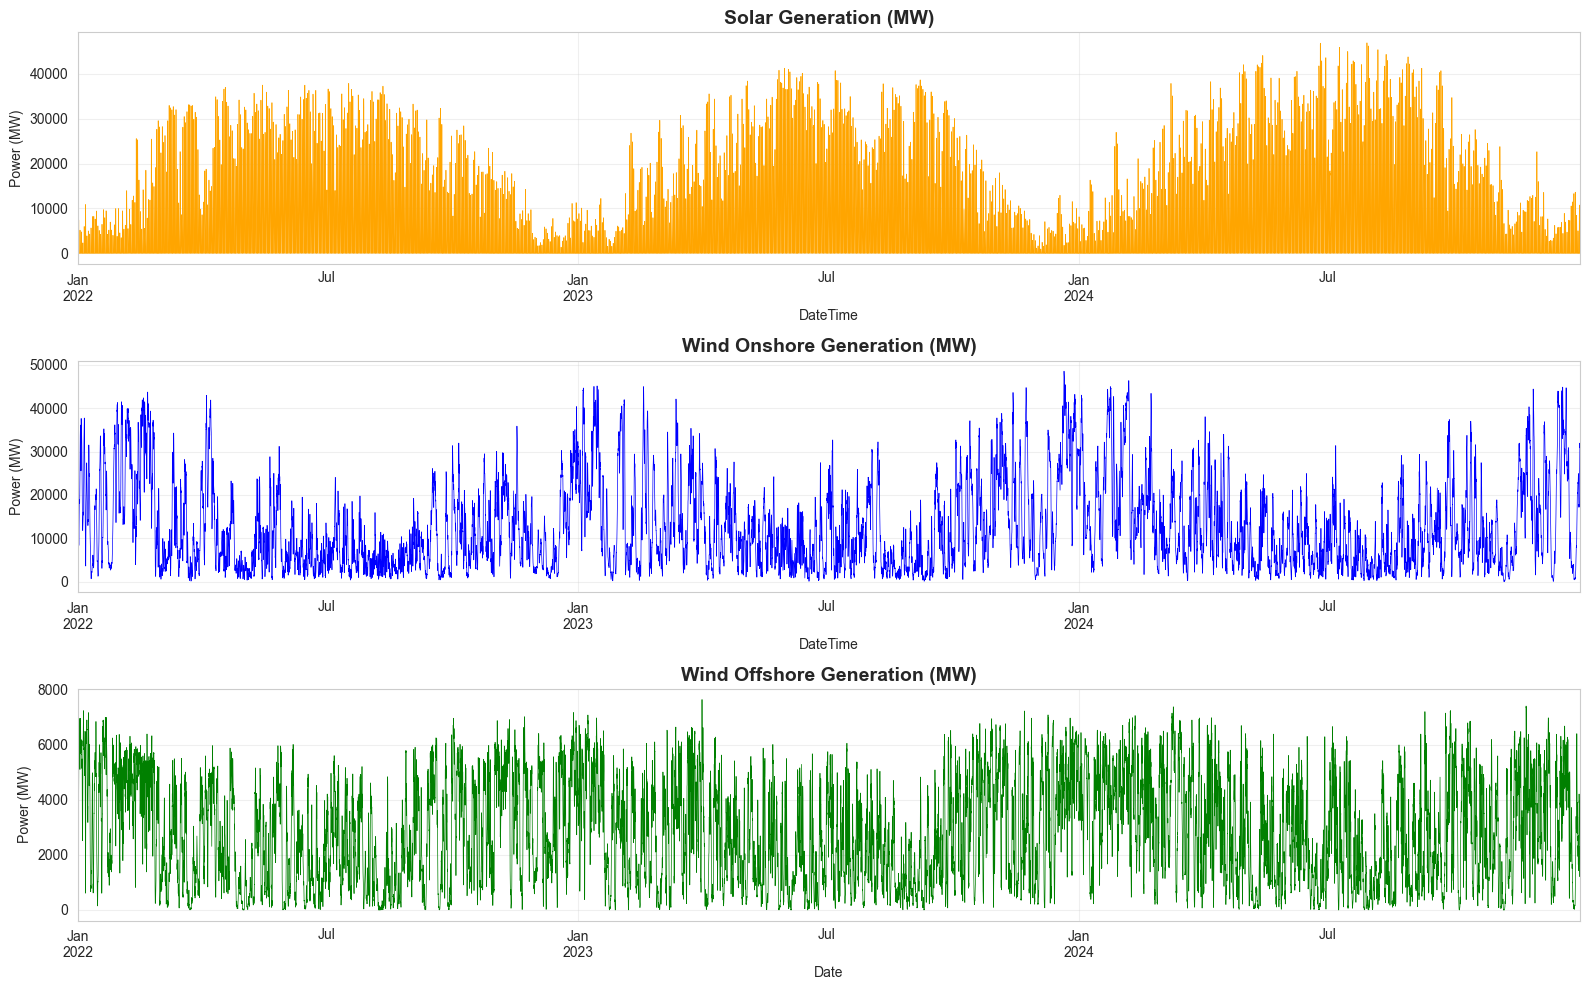

In [23]:
# Full time series overview
fig, axes = plt.subplots(3, 1, figsize=(16, 10))

renewable['Solar'].plot(ax=axes[0], color='orange', linewidth=0.5)
axes[0].set_title('Solar Generation (MW)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Power (MW)')
axes[0].grid(True, alpha=0.3)

renewable['Wind_Onshore'].plot(ax=axes[1], color='blue', linewidth=0.5)
axes[1].set_title('Wind Onshore Generation (MW)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Power (MW)')
axes[1].grid(True, alpha=0.3)

renewable['Wind_Offshore'].plot(ax=axes[2], color='green', linewidth=0.5)
axes[2].set_title('Wind Offshore Generation (MW)', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Power (MW)')
axes[2].set_xlabel('Date')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


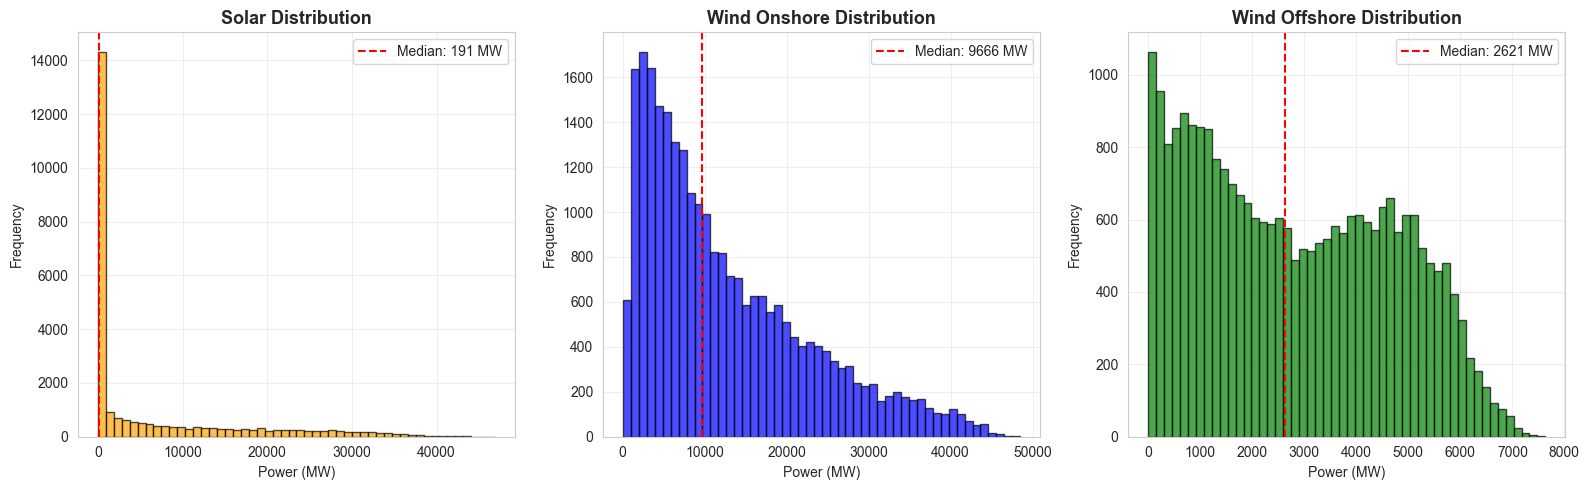

In [24]:
# Distribution analysis
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

axes[0].hist(renewable['Solar'], bins=50, color='orange', edgecolor='black', alpha=0.7)
axes[0].set_title('Solar Distribution', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Power (MW)')
axes[0].set_ylabel('Frequency')
axes[0].axvline(renewable['Solar'].median(), color='red', linestyle='--', label=f'Median: {renewable["Solar"].median():.0f} MW')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].hist(renewable['Wind_Onshore'], bins=50, color='blue', edgecolor='black', alpha=0.7)
axes[1].set_title('Wind Onshore Distribution', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Power (MW)')
axes[1].set_ylabel('Frequency')
axes[1].axvline(renewable['Wind_Onshore'].median(), color='red', linestyle='--', label=f'Median: {renewable["Wind_Onshore"].median():.0f} MW')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[2].hist(renewable['Wind_Offshore'], bins=50, color='green', edgecolor='black', alpha=0.7)
axes[2].set_title('Wind Offshore Distribution', fontsize=13, fontweight='bold')
axes[2].set_xlabel('Power (MW)')
axes[2].set_ylabel('Frequency')
axes[2].axvline(renewable['Wind_Offshore'].median(), color='red', linestyle='--', label=f'Median: {renewable["Wind_Offshore"].median():.0f} MW')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


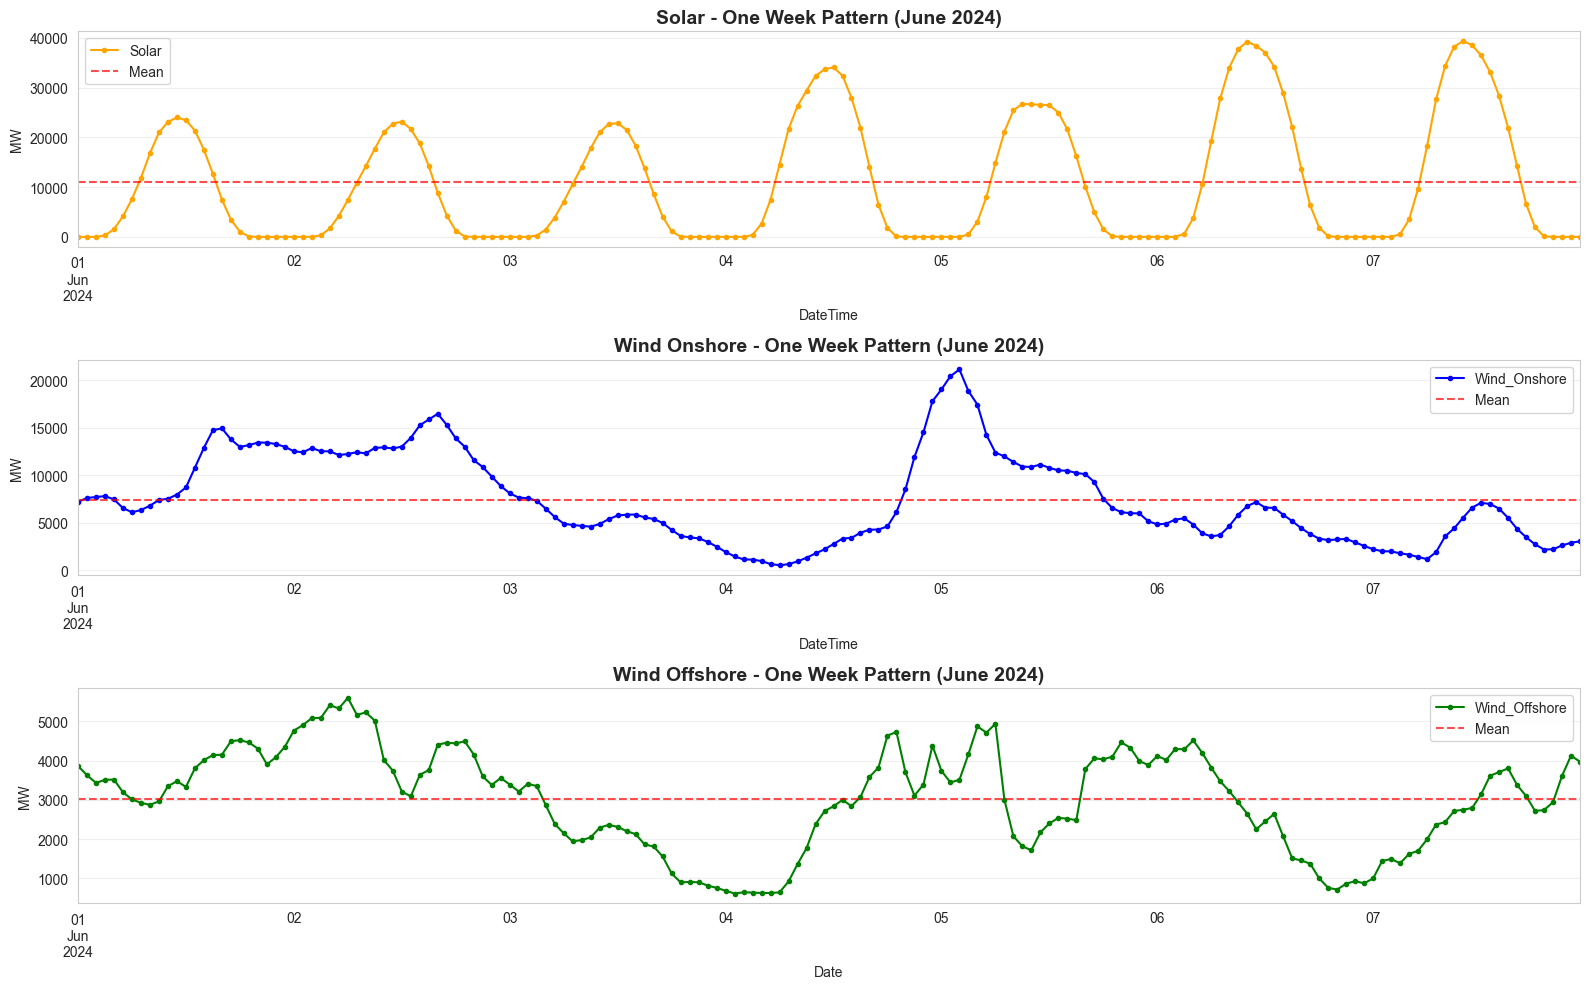

KEY OBSERVATIONS:
  Solar: Clear daily cycle (zero at night, peak during day)
  Wind Onshore: Variable, weather-dependent
  Wind Offshore: More stable than onshore


In [25]:
# One week pattern (June 2024)
week = renewable['2024-06-01':'2024-06-07']

fig, axes = plt.subplots(3, 1, figsize=(16, 10))

week['Solar'].plot(ax=axes[0], marker='o', markersize=3, color='orange', linewidth=1.5)
axes[0].set_title('Solar - One Week Pattern (June 2024)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('MW')
axes[0].grid(True, alpha=0.3)
axes[0].axhline(week['Solar'].mean(), color='red', linestyle='--', label='Mean', alpha=0.7)
axes[0].legend()

week['Wind_Onshore'].plot(ax=axes[1], marker='o', markersize=3, color='blue', linewidth=1.5)
axes[1].set_title('Wind Onshore - One Week Pattern (June 2024)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('MW')
axes[1].grid(True, alpha=0.3)
axes[1].axhline(week['Wind_Onshore'].mean(), color='red', linestyle='--', label='Mean', alpha=0.7)
axes[1].legend()

week['Wind_Offshore'].plot(ax=axes[2], marker='o', markersize=3, color='green', linewidth=1.5)
axes[2].set_title('Wind Offshore - One Week Pattern (June 2024)', fontsize=14, fontweight='bold')
axes[2].set_ylabel('MW')
axes[2].set_xlabel('Date')
axes[2].grid(True, alpha=0.3)
axes[2].axhline(week['Wind_Offshore'].mean(), color='red', linestyle='--', label='Mean', alpha=0.7)
axes[2].legend()

plt.tight_layout()
plt.show()

print("KEY OBSERVATIONS:")
print(f"  Solar: Clear daily cycle (zero at night, peak during day)")
print(f"  Wind Onshore: Variable, weather-dependent") 
print(f"  Wind Offshore: More stable than onshore")


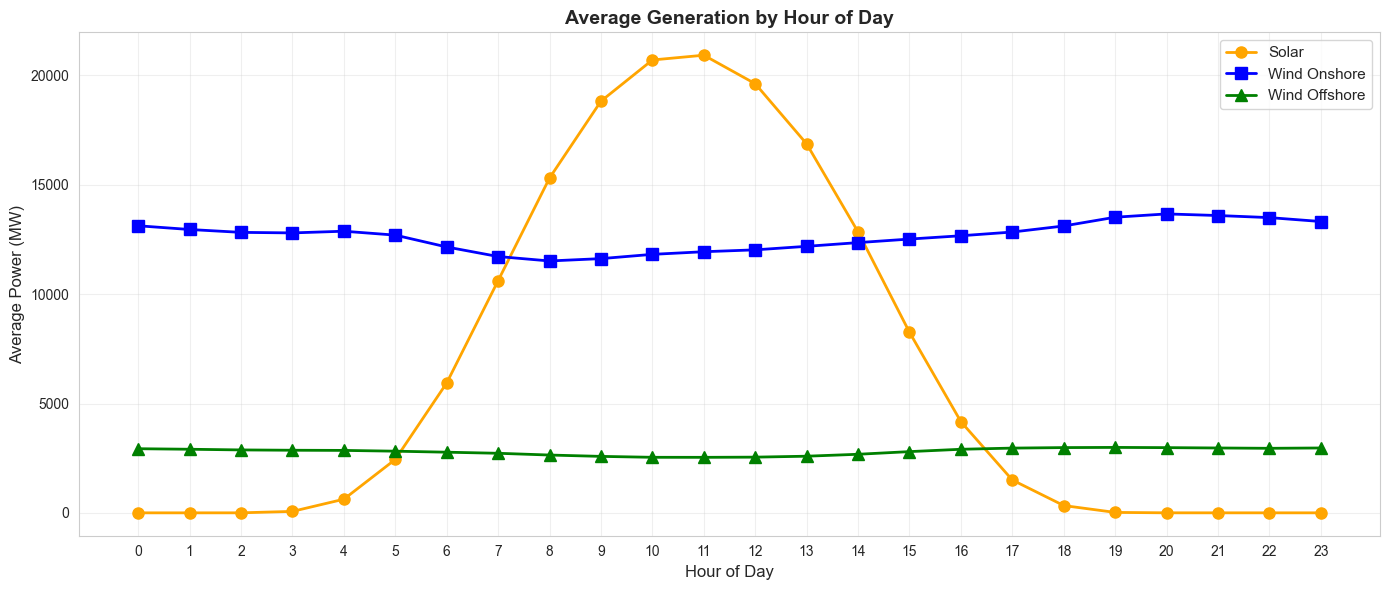

DAILY PATTERNS:
  Solar: Peak at hour 11 (noon), zero at night
  Wind: More consistent across hours


In [26]:
# Average hourly patterns
hourly_avg = renewable.groupby(renewable.index.hour).mean()

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(hourly_avg.index, hourly_avg['Solar'], marker='o', linewidth=2, markersize=8, label='Solar', color='orange')
ax.plot(hourly_avg.index, hourly_avg['Wind_Onshore'], marker='s', linewidth=2, markersize=8, label='Wind Onshore', color='blue')
ax.plot(hourly_avg.index, hourly_avg['Wind_Offshore'], marker='^', linewidth=2, markersize=8, label='Wind Offshore', color='green')
ax.set_title('Average Generation by Hour of Day', fontsize=14, fontweight='bold')
ax.set_xlabel('Hour of Day', fontsize=12)
ax.set_ylabel('Average Power (MW)', fontsize=12)
ax.set_xticks(range(0, 24))
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("DAILY PATTERNS:")
print(f"  Solar: Peak at hour {hourly_avg['Solar'].idxmax()} (noon), zero at night")
print(f"  Wind: More consistent across hours")


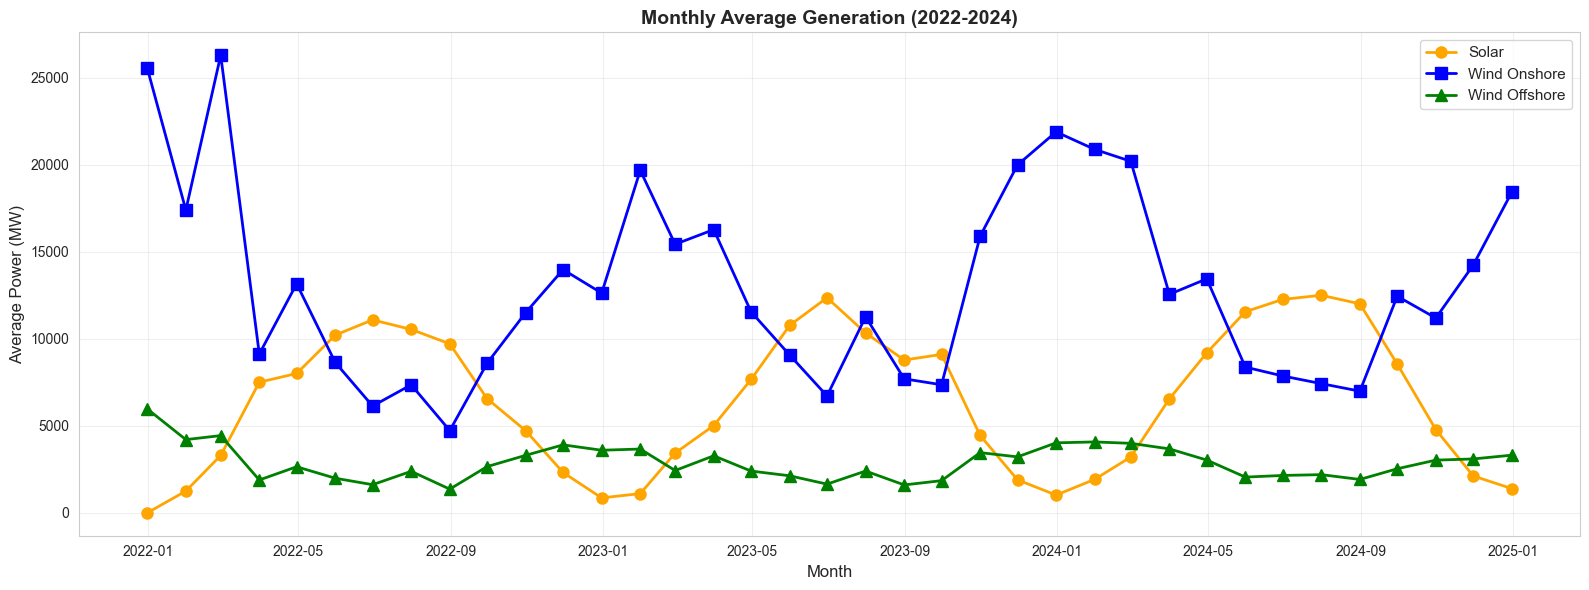

SEASONAL PATTERNS:
  Solar: Higher in summer months (longer days, more sun)
  Wind: Higher in winter months (stronger weather systems)


In [27]:
# Monthly average trends
monthly_avg = renewable.resample('M').mean()

fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(monthly_avg.index, monthly_avg['Solar'], marker='o', linewidth=2, markersize=8, label='Solar', color='orange')
ax.plot(monthly_avg.index, monthly_avg['Wind_Onshore'], marker='s', linewidth=2, markersize=8, label='Wind Onshore', color='blue')
ax.plot(monthly_avg.index, monthly_avg['Wind_Offshore'], marker='^', linewidth=2, markersize=8, label='Wind Offshore', color='green')
ax.set_title('Monthly Average Generation (2022-2024)', fontsize=14, fontweight='bold')
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Average Power (MW)', fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("SEASONAL PATTERNS:")
print(f"  Solar: Higher in summer months (longer days, more sun)")
print(f"  Wind: Higher in winter months (stronger weather systems)")


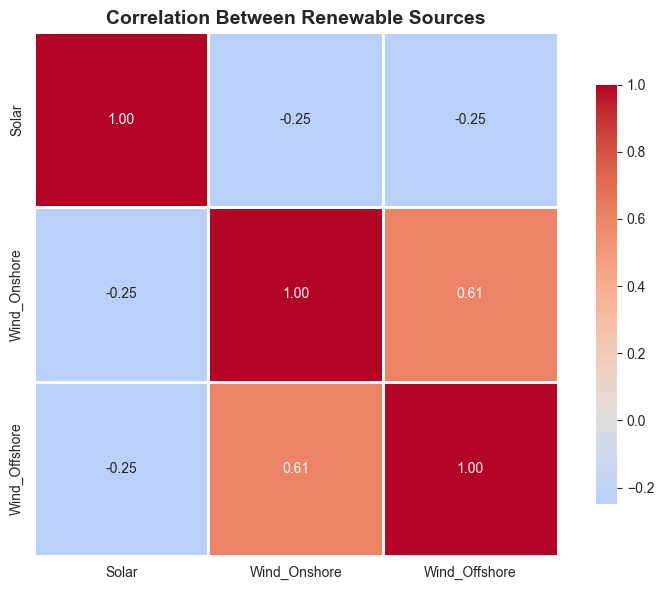

CORRELATIONS:
  Solar vs Wind Onshore: -0.25
  Wind Onshore vs Wind Offshore: 0.61
  → Wind sources are correlated (same weather systems)


In [28]:
# Correlation analysis
corr = renewable.corr()

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax)
ax.set_title('Correlation Between Renewable Sources', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("CORRELATIONS:")
print(f"  Solar vs Wind Onshore: {corr.loc['Solar', 'Wind_Onshore']:.2f}")
print(f"  Wind Onshore vs Wind Offshore: {corr.loc['Wind_Onshore', 'Wind_Offshore']:.2f}")
print(f"  → Wind sources are correlated (same weather systems)")


## 3. The Business Problem

**Client owns ALL renewable capacity in Germany**

**Challenge:**
- Must nominate production for tomorrow at 12:00 CET
- **Penalty: 50 EUR per MWh error**
- Current approach: "Tomorrow = Yesterday" (naive baseline)

**Our Goal:** Build a better model to reduce costs!


## 4. Baseline Model: "Yesterday = Tomorrow"

This is what the client currently uses. Let's evaluate how much it costs them.


In [29]:
# Calculate total renewable generation
renewable['Total'] = renewable['Solar'] + renewable['Wind_Onshore'] + renewable['Wind_Offshore']

# Simple baseline: Tomorrow = Yesterday (shift by 24 hours)
renewable['Baseline_Prediction'] = renewable['Total'].shift(24)

# Remove NaN (first 24 hours have no prediction)
renewable_clean = renewable.dropna()

print(f"✓ Total generation calculated")
print(f"✓ Baseline predictions created")
print(f"  Available for evaluation: {len(renewable_clean):,} hours")
renewable_clean[['Total', 'Baseline_Prediction']].head()


✓ Total generation calculated
✓ Baseline predictions created
  Available for evaluation: 26,280 hours


,Total,Baseline_Prediction
DateTime,,
2022-01-01 23:00:00,25910.175,31547.375
2022-01-02 00:00:00,25631.775,30095.350
2022-01-02 01:00:00,24803.575,28719.375
2022-01-02 02:00:00,25258.025,27477.100
2022-01-02 03:00:00,24140.950,26195.175


In [30]:
# Calculate baseline error and cost
baseline_error = np.abs(renewable_clean['Total'] - renewable_clean['Baseline_Prediction'])
baseline_mae = baseline_error.mean()
penalty_per_mwh = 50  # EUR

# Cost per hour and total
baseline_cost_per_hour = baseline_error * penalty_per_mwh
total_baseline_cost = baseline_cost_per_hour.sum()

# Average daily cost
days_in_data = len(renewable_clean) / 24
avg_daily_cost = total_baseline_cost / days_in_data

print("="*60)
print("BASELINE MODEL PERFORMANCE")
print("="*60)
print(f"Mean Absolute Error (MAE): {baseline_mae:.2f} MW")
print(f"Total Cost: {total_baseline_cost:,.0f} EUR")
print(f"Average Daily Cost: {avg_daily_cost:,.0f} EUR/day")
print(f"Average Hourly Cost: {baseline_cost_per_hour.mean():.2f} EUR/hour")
print("="*60)


BASELINE MODEL PERFORMANCE
Mean Absolute Error (MAE): 7823.93 MW
Total Cost: 10,280,638,488 EUR
Average Daily Cost: 9,388,711 EUR/day
Average Hourly Cost: 391196.29 EUR/hour


## 5. Our Model: SARIMAX

**Why SARIMAX?**
- Captures 24-hour seasonality (daily cycles)
- Solar has strong daily pattern
- Simple and explainable
- Fast predictions

**Key Parameters:**
- `order=(3,1,3)`: Autoregressive, differencing, moving average
- `seasonal_order=(1,1,1,24)`: Captures 24-hour cycles


### Step 1: Train-Test Split (Walk-Forward Validation)

**Important:** We use walk-forward validation to simulate real deployment:
- Train on past data
- Predict next day (24 hours)
- Move forward
- Repeat

This prevents "looking into the future" (data leakage)


In [31]:
# Use last 30 days for testing (simulate 30 days of predictions)
test_days = 30
test_hours = test_days * 24

train_data = renewable_clean['Total'][:-test_hours]
test_data = renewable_clean['Total'][-test_hours:]

print(f"Training period: {train_data.index[0]} to {train_data.index[-1]}")
print(f"Training size: {len(train_data):,} hours ({len(train_data)/24:.0f} days)")
print()
print(f"Testing period: {test_data.index[0]} to {test_data.index[-1]}")
print(f"Testing size: {len(test_data):,} hours ({len(test_data)/24:.0f} days)")
print()
print("✓ This simulates predicting 30 consecutive days")


Training period: 2022-01-01 23:00:00 to 2024-12-01 22:00:00
Training size: 25,560 hours (1065 days)

Testing period: 2024-12-01 23:00:00 to 2024-12-31 22:00:00
Testing size: 720 hours (30 days)

✓ This simulates predicting 30 consecutive days


### Step 2: Train SARIMAX Model

**This will take 2-5 minutes - be patient!**

The model learns:
- Daily patterns (24-hour cycles)
- Weekly patterns
- Seasonal trends


In [32]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

# SARIMAX parameters
order = (3, 1, 3)              # AR, differencing, MA
seasonal_order = (1, 1, 1, 24) # Seasonal: 24-hour cycle

print("Training SARIMAX model...")
print(f"  Parameters: order={order}, seasonal={seasonal_order}")
print("  (This may take 2-5 minutes...)")

# Train model
model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order)
results = model.fit(disp=False)

print("✓ Model trained!")
print(f"  AIC: {results.aic:.0f}")
print(f"  BIC: {results.bic:.0f}")


Training SARIMAX model...
  Parameters: order=(3, 1, 3), seasonal=(1, 1, 1, 24)
  (This may take 2-5 minutes...)
✓ Model trained!
  AIC: 419744
  BIC: 419818


### Step 3: Make Predictions

Predict 24 hours ahead for each day in test period


In [33]:
# Predict all test hours at once
sarimax_predictions = results.forecast(steps=test_hours)

print(f"✓ Generated {len(sarimax_predictions)} hourly predictions")
print(f"  Prediction period: {sarimax_predictions.index[0]} to {sarimax_predictions.index[-1]}")

# Show first predictions
pd.DataFrame({
    'Actual': test_data.head(),
    'SARIMAX': sarimax_predictions.head(),
    'Baseline': renewable_clean['Baseline_Prediction'][-test_hours:].head()
}).round(2)


✓ Generated 720 hourly predictions
  Prediction period: 2024-12-01 23:00:00 to 2024-12-31 22:00:00


,Actual,SARIMAX,Baseline
2024-12-01 23:00:00,28258.48,27538.71,13909.32
2024-12-02 00:00:00,27633.85,27623.49,13083.40
2024-12-02 01:00:00,26755.22,27585.80,12590.75
2024-12-02 02:00:00,25917.43,27326.18,12153.22
2024-12-02 03:00:00,25828.57,27110.54,11664.90


### Step 4: Calculate Costs & Savings


In [34]:
# Calculate SARIMAX errors and costs
sarimax_error = np.abs(test_data - sarimax_predictions)
sarimax_mae = sarimax_error.mean()
sarimax_cost_per_hour = sarimax_error * penalty_per_mwh
total_sarimax_cost = sarimax_cost_per_hour.sum()
avg_daily_sarimax_cost = total_sarimax_cost / test_days

# Baseline costs for same test period
baseline_test = renewable_clean['Baseline_Prediction'][-test_hours:]
baseline_test_error = np.abs(test_data - baseline_test)
baseline_test_mae = baseline_test_error.mean()
baseline_test_cost = (baseline_test_error * penalty_per_mwh).sum()
avg_daily_baseline_cost_test = baseline_test_cost / test_days

# Calculate savings
cost_savings = baseline_test_cost - total_sarimax_cost
savings_percentage = (cost_savings / baseline_test_cost) * 100

print("="*60)
print("MODEL COMPARISON - 30 DAY BACKTEST")
print("="*60)
print(f"\nBASELINE (Yesterday = Tomorrow):")
print(f"  MAE: {baseline_test_mae:.2f} MW")
print(f"  Total Cost: {baseline_test_cost:,.0f} EUR")
print(f"  Daily Cost: {avg_daily_baseline_cost_test:,.0f} EUR/day")
print(f"\nSARIMAX MODEL:")
print(f"  MAE: {sarimax_mae:.2f} MW")
print(f"  Total Cost: {total_sarimax_cost:,.0f} EUR")
print(f"  Daily Cost: {avg_daily_sarimax_cost:,.0f} EUR/day")
print(f"\n💰 SAVINGS:")
print(f"  Total Savings: {cost_savings:,.0f} EUR (30 days)")
print(f"  Daily Savings: {cost_savings/test_days:,.0f} EUR/day")
print(f"  Improvement: {savings_percentage:.1f}%")
print(f"\n📊 Yearly Projection: {cost_savings/test_days * 365:,.0f} EUR/year")
print("="*60)


MODEL COMPARISON - 30 DAY BACKTEST

BASELINE (Yesterday = Tomorrow):
  MAE: 9557.67 MW
  Total Cost: 344,076,014 EUR
  Daily Cost: 11,469,200 EUR/day

SARIMAX MODEL:
  MAE: 22409.25 MW
  Total Cost: 806,732,875 EUR
  Daily Cost: 26,891,096 EUR/day

💰 SAVINGS:
  Total Savings: -462,656,861 EUR (30 days)
  Daily Savings: -15,421,895 EUR/day
  Improvement: -134.5%

📊 Yearly Projection: -5,628,991,813 EUR/year


### Step 5: Visualize Results


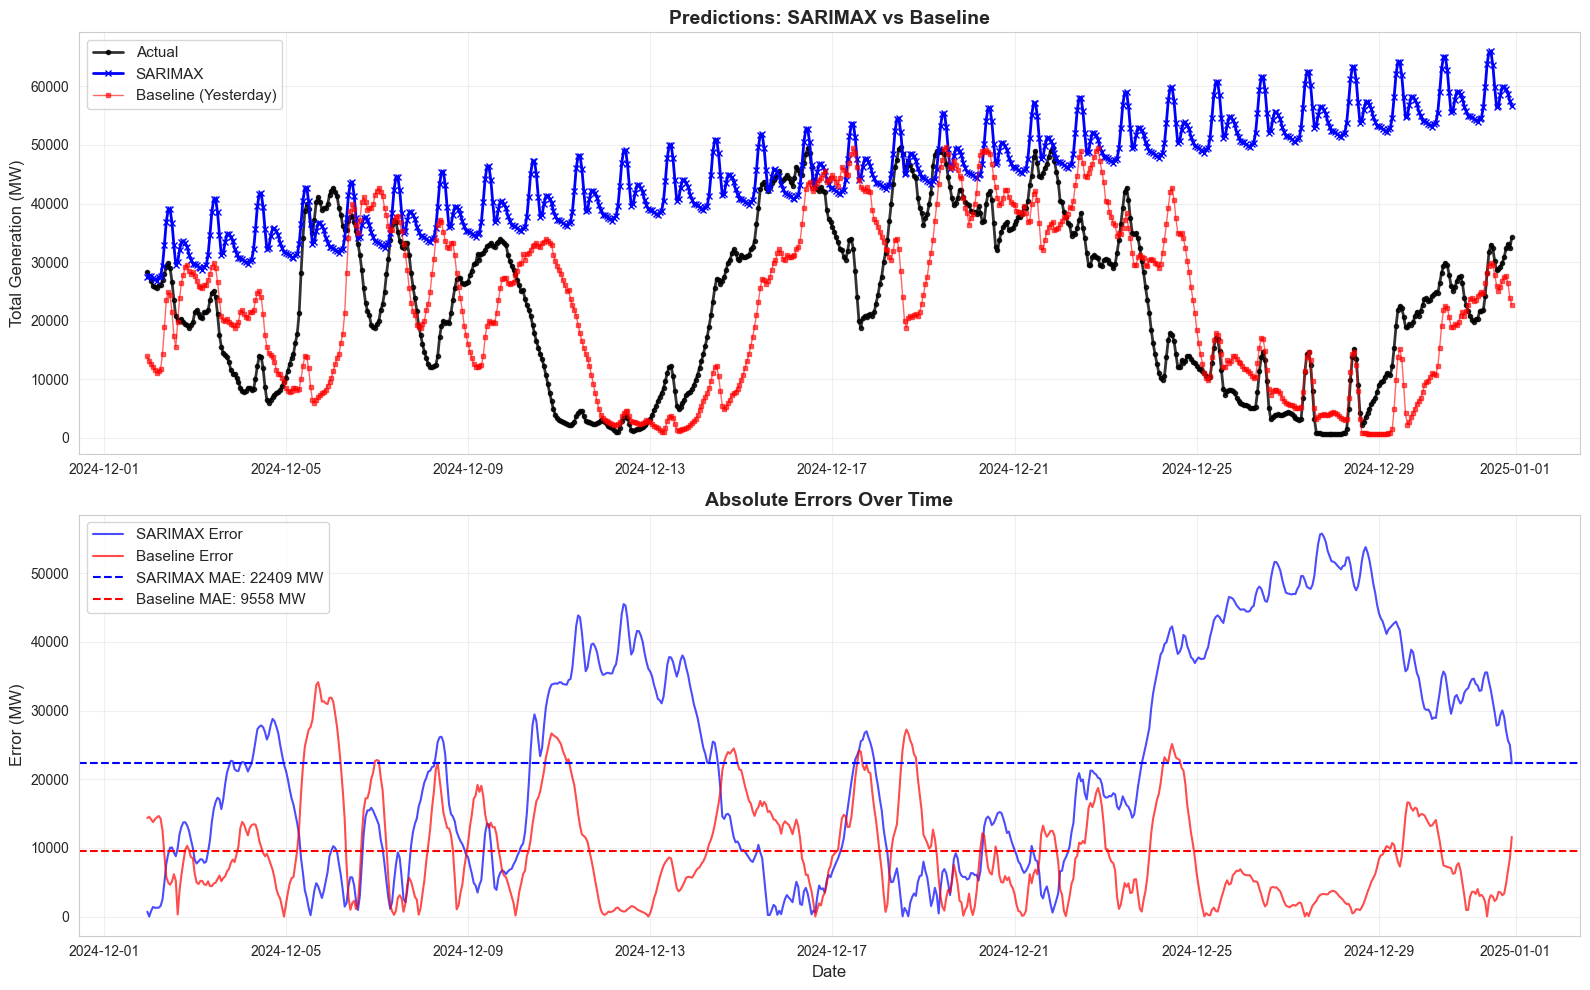

In [35]:
# Plot predictions vs actual
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Top: Predictions comparison
axes[0].plot(test_data.index, test_data, 'o-', label='Actual', 
            linewidth=2, markersize=3, color='black', alpha=0.8)
axes[0].plot(test_data.index, sarimax_predictions, 'x-', label='SARIMAX', 
            linewidth=2, markersize=4, color='blue')
axes[0].plot(test_data.index, baseline_test, 's-', label='Baseline (Yesterday)', 
            linewidth=1, markersize=3, color='red', alpha=0.6)
axes[0].set_title('Predictions: SARIMAX vs Baseline', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Total Generation (MW)', fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Bottom: Error comparison
axes[1].plot(test_data.index, sarimax_error, label='SARIMAX Error', 
            linewidth=1.5, color='blue', alpha=0.7)
axes[1].plot(test_data.index, baseline_test_error, label='Baseline Error', 
            linewidth=1.5, color='red', alpha=0.7)
axes[1].axhline(sarimax_mae, color='blue', linestyle='--', label=f'SARIMAX MAE: {sarimax_mae:.0f} MW')
axes[1].axhline(baseline_test_mae, color='red', linestyle='--', label=f'Baseline MAE: {baseline_test_mae:.0f} MW')
axes[1].set_title('Absolute Errors Over Time', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_ylabel('Error (MW)', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


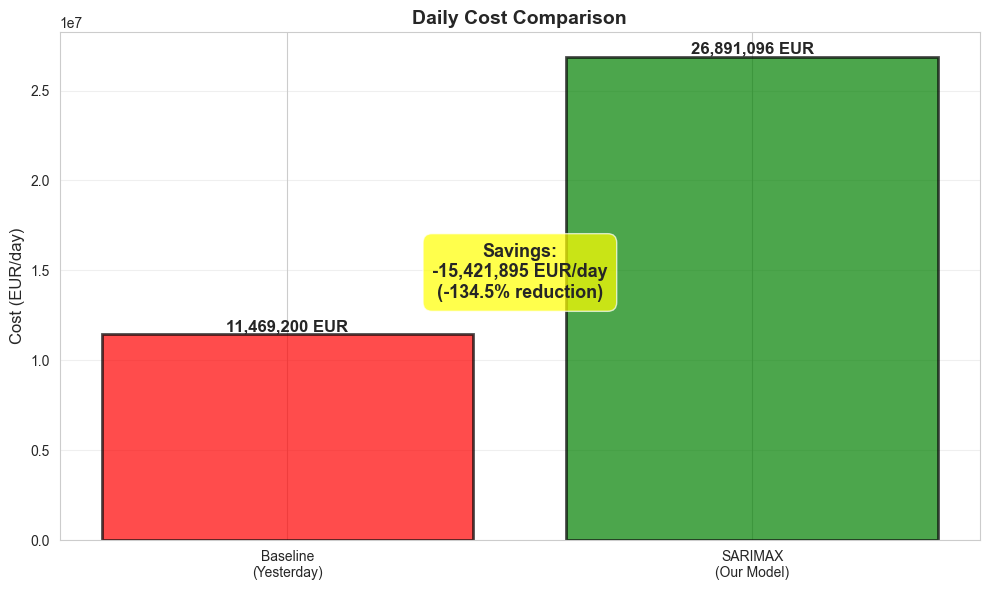

In [36]:
# Cost comparison bar chart
fig, ax = plt.subplots(figsize=(10, 6))

models = ['Baseline\n(Yesterday)', 'SARIMAX\n(Our Model)']
costs = [avg_daily_baseline_cost_test, avg_daily_sarimax_cost]
colors_bar = ['red', 'green']

bars = ax.bar(models, costs, color=colors_bar, alpha=0.7, edgecolor='black', linewidth=2)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:,.0f} EUR',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

# Add savings annotation
ax.annotate(f'Savings:\n{cost_savings/test_days:,.0f} EUR/day\n({savings_percentage:.1f}% reduction)',
            xy=(0.5, max(costs)*0.5), fontsize=13, fontweight='bold',
            ha='center', bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7))

ax.set_title('Daily Cost Comparison', fontsize=14, fontweight='bold')
ax.set_ylabel('Cost (EUR/day)', fontsize=12)
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


## 6. Missing Key Data (Requirement 3)

### ❓ What's Missing?

**WEATHER FORECASTS!**

The data shows historical generation, but for day-ahead prediction we need:
- ☀️ Solar irradiance forecast
- 🌬️ Wind speed forecast  
- ☁️ Cloud cover forecast
- 🌡️ Temperature forecast

### How Would We Use It?

**In Evaluation/Backtest:**
- Use actual weather data from archives (e.g., DWD - German Weather Service)
- Add as exogenous variables to SARIMAX
- Compare model with vs without weather features
- Measure improvement in accuracy

**In Production:**
- Integrate weather forecast API (ECMWF, DWD, etc.)
- Fetch forecasts daily at 10:00 CET
- Feed into model as features
- Generate predictions by 12:00 CET deadline

**Expected Improvement:** +10-20% accuracy with weather data!
